In [2]:
%load_ext autoreload
%autoreload 2
from ga.numba_ga import GaHMM
from data.data import Observations
import pandas
import ga.crossover as crossover
import ga.mutation as mutation
import numpy
import seaborn as sns
import hmm.bw as bw
import ga.representation as representation
from ga.numba_ga import normalize_population, calculate_fitness_of_population, train_population_with_bw

In [3]:
mutation_df = pandas.read_csv('evaluation/mutation_df.csv')
crossover_df = pandas.read_csv('evaluation/crossover_df.csv')

In [10]:
# crossover_df.groupby(['n_bw_iterations', 'crossover_func'])['parent1_fitness', 'parent2_fitness']
crossover_df['parents_max'] = crossover_df[['parent1_fitness', 'parent2_fitness']].max(axis=1)
crossover_df

,Unnamed: 0,dataset,n_seqs,n_symbols,n_states,n_bw_iterations,crossover_func,parent1_fitness,parent2_fitness,child_fitness,parents_max
0,0,fsdd,10,128,5,0,1X,-2794.816316,-2696.964505,-2677.282638,-2696.964505
1,1,fsdd,10,128,5,0,1X,-2744.383492,-2876.580886,-2870.574750,-2744.383492
2,2,fsdd,10,128,5,0,1X,-2996.673561,-2873.807386,-2915.896882,-2873.807386
3,3,fsdd,10,128,5,0,1X,-3004.350557,-2995.510869,-3009.897606,-2995.510869
4,4,fsdd,10,128,5,0,1X,-2809.398291,-2796.122859,-2776.905932,-2796.122859
...,...,...,...,...,...,...,...,...,...,...,...
41995,41995,fsdd,10,128,5,20,UNIFORM,-1235.294178,-1083.416429,-inf,-1083.416429
41996,41996,fsdd,10,128,5,20,UNIFORM,-1076.300941,-1234.497748,-inf,-1076.300941
41997,41997,fsdd,10,128,5,20,UNIFORM,-1117.196537,-1201.605450,-5916.383755,-1117.196537
41998,41998,fsdd,10,128,5,20,UNIFORM,-1225.867331,-1279.851797,-1716.801261,-1225.867331


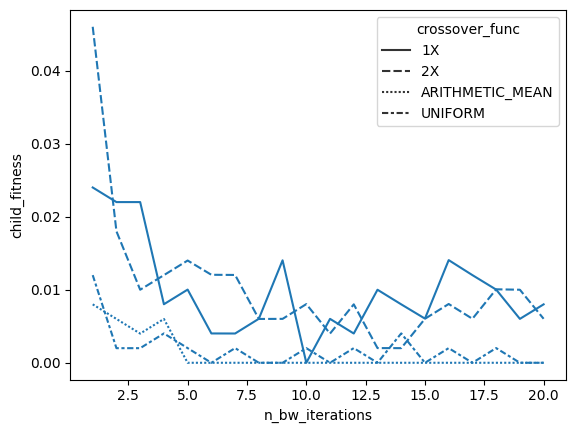

In [22]:
def how_often_is_crossover_better(crossover_df: pandas.DataFrame):
    crossover_df = crossover_df[crossover_df['n_bw_iterations'] > 0]
    child_is_fitter_than_both_parents = crossover_df[crossover_df['child_fitness'] > crossover_df['parents_max']]
    how_often_is_child_fitter = child_is_fitter_than_both_parents.groupby(['crossover_func', 'n_bw_iterations'])['child_fitness'].count()
    out_of = crossover_df.groupby(['crossover_func', 'n_bw_iterations'])['child_fitness'].count()

    soos = (how_often_is_child_fitter / out_of).fillna(0)
    
    df = pandas.DataFrame(soos).reset_index()
    sns.lineplot(df, x='n_bw_iterations', y='child_fitness', style='crossover_func')
    # df = df.pivot('crossover_func', 'n_bw_iterations', 'child_fitness')
    # sns.heatmap(df)
    # return df

how_often_is_crossover_better(crossover_df)

In [22]:
mutation_df['fitness_increase'] = (mutation_df['fitness_after_mutation'] - mutation_df['fitness_before_mutation'])
# mutation_df

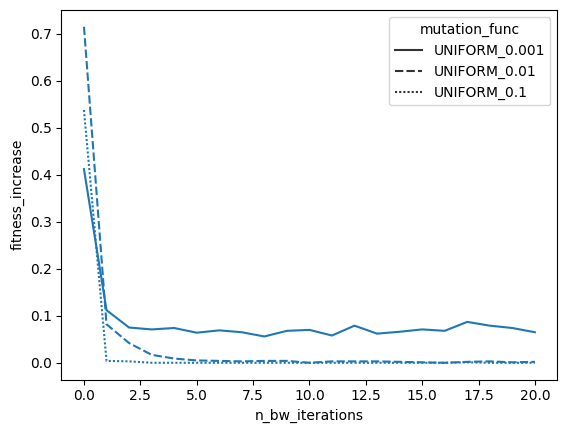

In [46]:
def how_often_is_mutation_better(mutation_df: pandas.DataFrame):

    did_improve = mutation_df[mutation_df['fitness_increase'] > 0].groupby(['mutation_func', 'n_bw_iterations'])['fitness_increase'].count()
    out_of = mutation_df.groupby(['mutation_func', 'n_bw_iterations'])['fitness_increase'].count()

    soos = (did_improve / out_of).fillna(0)
    
    df = pandas.DataFrame(soos).reset_index()
    sns.lineplot(df, x='n_bw_iterations', y='fitness_increase', style='mutation_func')

how_often_is_mutation_better(mutation_df)

<AxesSubplot: xlabel='n_bw_iterations', ylabel='percentage_increase'>

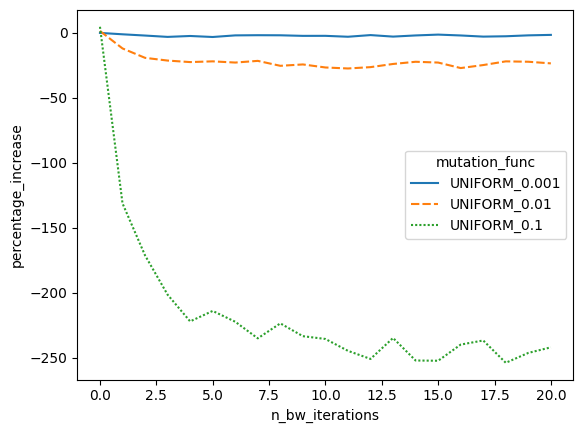

In [17]:
series = mutation_df.groupby(['n_bw_iterations', 'mutation_func'])['percentage_increase'].mean()
df = pandas.DataFrame(series).reset_index()
sns.lineplot(df, x='n_bw_iterations', y='percentage_increase', style='mutation_func', hue='mutation_func')

In [ ]:
mutation_df[mutation_df['n_bw_iterations'] == 0].mean()

In [12]:
series = mutation_df.groupby(['mutation_func', 'n_bw_iterations'])['fitness_after_mutation'].mean()
df = pandas.DataFrame(series).reset_index()
# sns.lineplot(df, x='n_bw_iterations', y='fitness_after_mutation', style='mutation_func')

<AxesSubplot: xlabel='n_bw_iterations', ylabel='fitness_after_mutation'>

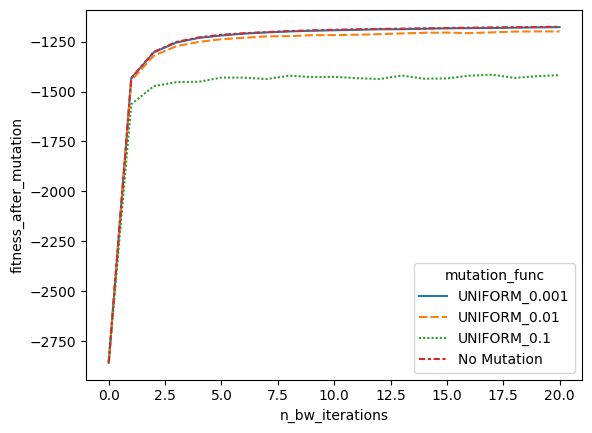

In [14]:
df2 = mutation_df.groupby('n_bw_iterations')['fitness_before_mutation'].mean()

# sns.scatterplot(mutation_df, x='fitness_before_mutation', y='fitness_after_mutation', hue='mutation_func')
# mutation_df[mutation_df['n_bw_iterations'] == 0]
# pandas.concat(df, df2)
df2 = pandas.DataFrame(df2).reset_index()
df2['mutation_func'] = 'No Mutation'
df2 = df2.rename(columns={'fitness_before_mutation': 'fitness_after_mutation'})
df3 = pandas.concat([df, df2])
sns.lineplot(df3, x='n_bw_iterations', y='fitness_after_mutation', style='mutation_func', hue='mutation_func')